_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
from numpy import array

## Pretraining

The `capa_intermittency.dat` feeds the model with the dynamics of the Capacitor

In [3]:
data = np.genfromtxt('capa_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,0]

## Computing the Gradient

_Calculating the value of_ $\frac{dx}{dt}$

In [4]:
t_diff = 1
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:] # dx/dt
print(gradient_t)

1.0
1        0.000298
2        0.000298
3        0.000297
4        0.000297
5        0.000297
           ...   
9996     0.000018
9997     0.000018
9998     0.000018
9999     0.000018
10000    0.000018
Name: 0, Length: 10000, dtype: float64


## Loading Datasets

In [ ]:
data = pd.read_csv("c8_interpolated_1950_100.csv")
training_set = data.iloc[:, 1]
training_set

0       88.200000
1       87.987115
2       87.774230
3       87.561345
4       87.348459
          ...    
2045    59.052299
2046    59.047164
2047    59.042028
2048    59.036893
2049    59.031758
Name: C8, Length: 2050, dtype: float64

In [6]:
test = training_set.tail(100)
test
training_set = training_set.head(1950)
training_set

0       88.200000
1       87.987115
2       87.774230
3       87.561345
4       87.348459
          ...    
1945     0.000000
1946     0.146881
1947     0.000000
1948     0.143897
1949     0.427304
Name: C8, Length: 1950, dtype: float64

In [7]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
print(gradient_t)

0       0.000298
1       0.000298
2       0.000297
3       0.000297
4       0.000297
          ...   
9995    0.000018
9996    0.000018
9997    0.000018
9998    0.000018
9999    0.000018
Name: 0, Length: 10000, dtype: float64


In [8]:
df = pd.concat((training_set, gradient_t), axis=1)
df.columns = ['y_t', 'grad_t']

In [9]:
df

,y_t,grad_t
0,88.200000,0.000298
1,87.987115,0.000298
2,87.774230,0.000297
3,87.561345,0.000297
4,87.348459,0.000297
...,...,...
9995,NaN,0.000018
9996,NaN,0.000018
9997,NaN,0.000018
9998,NaN,0.000018


## Plot of the External Forcing from Chaotic Differential Equation

<Axes: >

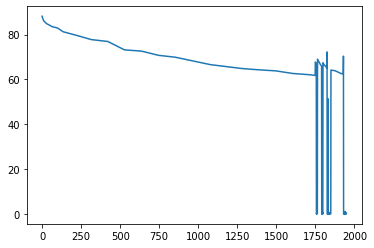

In [10]:
df.iloc[:, 0].plot()

C:\Users\Anurag Dutta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

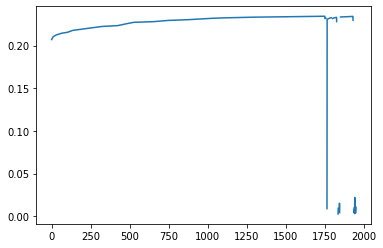

In [11]:
import numpy as np
c0 = 85.7336  # Value for C0
K0 = -0.0020  # Value for K0
K1 = 0.0002  # Value for K1
a = 0.0000    # Value for a
b = 0.0125    # Value for b
c = 2.3008    # Value for c

L = np.minimum(c0, (df.iloc[:, 1] - (df.iloc[:, 0] * (K0 - K1 * (9 * a * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c)**2 + 4 * b * np.log(df.iloc[:, 0] / c0) / (K0 - K1 * c) + c)))))
L.plot()

## Preprocessing the data into supervised learning

In [12]:
# split a sequence into samples
def Supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n_in, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n_out)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
       agg.dropna(inplace=True)
    return agg

In [13]:
data = Supervised(df.values, n_in = 350, n_out = 100)


cols_to_drop = []
for i in range(2, 351):
    cols_to_drop.extend([f'var2(t-{i})'])

data.drop(cols_to_drop, axis=1, inplace=True)

print(data.head())
print(data.columns)

     var1(t-350)  var1(t-349)  var1(t-348)  var1(t-347)  var1(t-346)  \
350    88.200000    87.987115    87.774230    87.561345    87.348459   
351    87.987115    87.774230    87.561345    87.348459    87.135574   
352    87.774230    87.561345    87.348459    87.135574    86.922689   
353    87.561345    87.348459    87.135574    86.922689    86.709804   
354    87.348459    87.135574    86.922689    86.709804    86.496919   

     var1(t-345)  var1(t-344)  var1(t-343)  var1(t-342)  var1(t-341)  ...  \
350    87.135574    86.922689    86.709804    86.496919    86.294538  ...   
351    86.922689    86.709804    86.496919    86.294538    86.221709  ...   
352    86.709804    86.496919    86.294538    86.221709    86.148880  ...   
353    86.496919    86.294538    86.221709    86.148880    86.076050  ...   
354    86.294538    86.221709    86.148880    86.076050    86.003221  ...   

     var1(t+95)  var2(t+95)  var1(t+96)  var2(t+96)  var1(t+97)  var2(t+97)  \
350   76.094351    0.0002

In [14]:
train = np.array(data[0:len(data)-1])
forecast = np.array(data.tail(1))

In [15]:
trainy = train[:,-300:]
trainX = train[:,:-300]

In [16]:
forecasty = forecast[:,-300:]
forecastX = forecast[:,:-300]

In [17]:
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
forecastX = forecastX.reshape((forecastX.shape[0], 1, forecastX.shape[1]))
print(trainX.shape, trainy.shape, forecastX.shape)

(1500, 1, 251) (1500, 300) (1, 1, 251)


In [18]:
C0 = tf.Variable(85.7336, name="C0", trainable=True, dtype=tf.float32)
K0 = tf.Variable(-0.0020, name="K0", trainable=True, dtype=tf.float32)
K1 = tf.Variable(-0.0002, name="K1", trainable=True, dtype=tf.float32)
a = tf.Variable(0.0000, name="a", trainable=True, dtype=tf.float32)
b = tf.Variable(0.0125, name="b", trainable=True, dtype=tf.float32)
c = tf.Variable(2.3008, name="c", trainable=True, dtype=tf.float32)

splitr = 0.8


def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    #squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    #squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    epsilon = 1
    squared_difference3 = tf.square(
        y_pred[:, 1] - (
            y_pred[:, 0] * (
                K0 - K1 * (
                    9 * a * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c)**2 +
                    4 * b * tf.math.log((y_pred[:, 0] + epsilon) / C0) / (K0 - K1 * c) + c
                )
            )
        )
    )
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(60))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX[:int(splitr*trainX.shape[0])], trainy[:int(splitr*trainX.shape[0])], epochs=500, batch_size=64, validation_data=(trainX[int(splitr*trainX.shape[0]):trainX.shape[0]], trainy[int(splitr*trainX.shape[0]):trainX.shape[0]]), shuffle=False)

Epoch 1/500
19/19 [==============================] - 2s 25ms/step - loss: 4831.7920 - val_loss: 3806.5513
Epoch 2/500
19/19 [==============================] - 0s 4ms/step - loss: 4750.9004 - val_loss: 3759.7634
Epoch 3/500
19/19 [==============================] - 0s 4ms/step - loss: 4696.8477 - val_loss: 3695.2778
Epoch 4/500
19/19 [==============================] - 0s 4ms/step - loss: 4625.3560 - val_loss: 3646.5024
Epoch 5/500
19/19 [==============================] - 0s 4ms/step - loss: 4570.9292 - val_loss: 3598.3008
Epoch 6/500
19/19 [==============================] - 0s 4ms/step - loss: 4517.3027 - val_loss: 3550.8701
Epoch 7/500
19/19 [==============================] - 0s 4ms/step - loss: 4464.4390 - val_loss: 3504.0891
Epoch 8/500
19/19 [==============================] - 0s 4ms/step - loss: 4412.2231 - val_loss: 3457.8789
Epoch 9/500
19/19 [==============================] - 0s 4ms/step - loss: 4360.5859 - val_loss: 3412.1938
Epoch 10/500
19/19 [==============================] - 

In [19]:
forecast_without_mc = forecastX
yhat_without_mc = model.predict(forecast_without_mc) # Step Ahead Prediction
forecast_without_mc = forecast_without_mc.reshape((forecast_without_mc.shape[0], forecast_without_mc.shape[2])) # Historical Input

1/1 [==============================] - 0s 366ms/step


In [20]:
forecastX.shape

(1, 1, 251)

In [21]:
forecast_without_mc.shape

(1, 251)

In [22]:
inv_yhat_without_mc = np.concatenate((forecast_without_mc, yhat_without_mc), axis=1) # Concatenation of predicted values with Historical Data
#inv_yhat_without_mc = scaler.inverse_transform(inv_yhat_without_mc) # Transform labels back to original encoding

In [23]:
inv_yhat_without_mc.shape

(1, 311)

In [24]:
fforecast = inv_yhat_without_mc[:,-300:]

In [25]:
fforecast.shape

(1, 300)

In [26]:
final_forecast = fforecast[:,0:300:3]

In [27]:
fforecast.shape

(1, 300)

In [28]:
# code to replace all negative value with 0
final_forecast[final_forecast<0] = 0

In [29]:
final_forecast

array([[6.36700280e+01, 6.36364146e+01, 6.36028011e+01, 6.35691877e+01,
        6.35355742e+01, 6.35019608e+01, 6.34683473e+01, 6.34347339e+01,
        6.34011205e+01, 6.33675070e+01, 6.33338936e+01, 6.33002801e+01,
        6.32666667e+01, 6.32330532e+01, 6.31994398e+01, 6.31658263e+01,
        6.31322129e+01, 6.30985994e+01, 6.30649860e+01, 6.30313726e+01,
        6.29977591e+01, 6.29641457e+01, 6.29305322e+01, 6.28969188e+01,
        6.28633053e+01, 6.28296919e+01, 6.27960784e+01, 6.27624650e+01,
        6.27288515e+01, 6.26980159e+01, 6.26840103e+01, 6.26700047e+01,
        6.26559991e+01, 6.26419935e+01, 6.26279879e+01, 6.26139823e+01,
        6.25999767e+01, 6.25859711e+01, 6.25719655e+01, 6.25579599e+01,
        6.25439542e+01, 6.25299487e+01, 6.25159430e+01, 6.25019374e+01,
        6.24879318e+01, 6.24739262e+01, 6.24599206e+01, 6.24459150e+01,
        6.24319094e+01, 6.24179038e+01, 6.24038982e+01, 6.23898926e+01,
        6.23758870e+01, 6.23618814e+01, 6.23478758e+01, 6.233387

In [30]:
final_forecast.shape

(1, 100)

In [31]:
test.shape

(100,)

In [32]:
training_set = np.array(training_set)
test = np.array(test)
final_forecast = np.array(final_forecast.squeeze(0))

In [33]:
test

array([59.54016106, 59.53502568, 59.52989029, 59.5247549 , 59.51961951,
       59.51448413, 59.50934874, 59.50421335, 59.49907796, 59.49394258,
       59.48880719, 59.4836718 , 59.47853641, 59.47340103, 59.46826564,
       59.46313025, 59.45799486, 59.45285948, 59.44772409, 59.4425887 ,
       59.43745331, 59.43231793, 59.42718254, 59.42204715, 59.41691176,
       59.41177638, 59.40664099, 59.4015056 , 59.39637021, 59.39123483,
       59.38609944, 59.38096405, 59.37582866, 59.37069328, 59.36555789,
       59.3604225 , 59.35528711, 59.35015173, 59.34501634, 59.33988095,
       59.33474556, 59.32961018, 59.32447479, 59.3193394 , 59.31420401,
       59.30906863, 59.30393324, 59.29879785, 59.29366246, 59.28852708,
       59.28339169, 59.2782563 , 59.27312092, 59.26798553, 59.26285014,
       59.25771475, 59.25257937, 59.24744398, 59.24230859, 59.2371732 ,
       59.23203782, 59.22690243, 59.22176704, 59.21663165, 59.21149627,
       59.20636088, 59.20122549, 59.1960901 , 59.19095472, 59.18

In [34]:
test.shape

(100,)

In [35]:
final_forecast.shape

(100,)

In [36]:
test.shape

(100,)

In [37]:
import math
MSE = np.square(np.subtract(np.array(test),np.array(final_forecast))).mean()   
rsme = math.sqrt(MSE)
print(rsme)  
MAE = np.abs(np.subtract(np.array(test),np.array(final_forecast))).mean()   
mae = MAE
print(mae)

25.86918776272012
13.940394636211538
